# Trial simulation computational practical
<hr style="border:1px solid gray">
<hr style="border:1px solid gray">
<br></br>

## Introduction
In this notebook we will simulate and analyze clinical trial data for hypothetical [randomized controlled trials](https://en.wikipedia.org/wiki/Randomized_controlled_trial) (RCTs) and [observational studies](https://en.wikipedia.org/wiki/Observational_study). By comparing the two we will gain a hands-on understanding of the problem of [confounding](https://en.wikipedia.org/wiki/Confounding).

### The Problem
The trials we will simulate are investigating the impact of some treatment $T$ on the survival rate of a deadly disease. We will analyze our trial data using logistic regression. [Regression](https://en.wikipedia.org/wiki/Regression_analysis) means we fitting a model to our data by tuning some parameters and finding the the values of those parameters which maximise the accuracy of the model. [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) means modelling the probability of death as a logistic function of $T$, given by

$$ P(D=1|T) = \left[1+\exp\left(-\beta_0 - \beta_1 T\right)\right]^{-1}, $$

where $D=1,0$ denotes death/survival, $T=1,0$ denotes treatment/no treatment, and $\beta_{0,1}$ are the regression paramters. We will refer to the estimates of these parameters (the values which maximise the model's accuracy) as $\hat{\beta}_{0,1}$. With this form of the probability the [odds](https://en.wikipedia.org/wiki/Odds) of death, defined as the ratio of death probability to survival probability, are given by

$$ \text{Odds}(D=1|T) = \frac{P(D=1|T)}{P(D=0|T)} = \frac{P(D=1|T)}{1-P(D=1|T)} = \exp\left(\beta_0 + \beta_1 T\right).$$

The [odds ratio](https://en.wikipedia.org/wiki/Odds_ratio) (OR) between the treated and untreated groups is then the exponential of $\beta_1$, the regression coefficient of $T$

$$ OR = \frac{\text{Odds}(D=1|T=1)}{\text{Odds}(D=1|T=0)} = \frac{\exp\left(\beta_0 + \beta_1\right)}{\exp\left(\beta_0\right)} = \exp\left(\beta_1\right).$$

### Odds ratio

The OR in principle tells us the average effect of the treatment in the sample. If the treatment improves each patient's chance of survival then we should find $OR < 1$. Conversely, $OR>1$ indicates that the treatment worsens survival odds, and $OR=1$ indicates no treatment effect.

Another way of putting this is that $\beta_1$ is equal to the log of the odds ratio: $ \beta_1 = \ln{OR} $. If $\beta_1$ is positive then the treatment appears to increase survival odds, while $\beta_1<0$ suggests that the treatment decreases survival odds, and $\beta_1=0$ indicates no effect.

Due to chance, the odds ratio we measure from a trial will almost always be a little different to the true OR. In fact, even if the treatment did nothing we would not expect to obtain an $OR=1$. This would mean that the survival rate in the treatment group and control group was identical, which is very unlikely even if the groups are taking the same treatment.

We therefore need a way to see if the odds ratio is "[statistically significant](https://en.wikipedia.org/wiki/Statistical_significance)".

### Statistical significance

To measure statistical significance we will use the [p-value](https://en.wikipedia.org/wiki/P-value) of the regression estimate $\hat{\beta}_1$. We will also output the 95% [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) for $\hat{\beta}_1$, which is an equivalent way of measuring statistical significance.

The proper meaning of the p-value and confidence interval is rather technical and you don't need to understand it. Just know that a small p-value and a narrow confidence interval indicates a "significant" result which we can more confidently attribute to a real treatment effect.

Conventionally, we compare the p-value to some significance threshold $\alpha$ (conventionally $\alpha=0.05$, i.e. $5\%$). If $p < \alpha$ we say the result is significant, otherwise it isn't.


### Simulations

The steps of each simulated trial will be as follows:
1. Generate simulated trial data
2. Analyze the data using logistic regression
3. Extract $\hat{\beta}_1$, its p-value, and its confidence interval, from the regression
4. Compute the estimated odds ratio $\hat{OR} = \exp{\hat{\beta}_1}$
5. Determine if the trial was a success ($\hat{OR} < 1$ and $p < \alpha$)

<br></br>
<hr style="border:1px solid gray">
<br></br>

## Global variables, packages, and functions

### Package import
First, we import any packages we might need.

In [4]:
import numpy as np # So that python can do maths for us
import pandas as pd # Pandas is a great package for handling data
import matplotlib.pyplot as plt # In case we want to plot anything
import statsmodels.api as sm # This package will perform logistic regression for us
# statsmodels will also calculate p values, standard errors, and confidence intervals for us

### Global variables
Here is where we will set parameters common to all our simulations.

In [6]:
nPatients = 1000 # Number of patients in each trial

controlDeathProb = 0.5 # Probability of mortality with no treatment
treatmentRelativeRisk = 0.75 # Factor by which treatment reduces your probability of death
treatmentDeathProb = controlDeathProb*treatmentRelativeRisk # Probability of death with treatment

nSims = 1000 # Number of times we will simulate each trial
statSigThreshold = 0.05 # statistical significance threshold for p values and confidence intervals

It's also worth here looking at the true odds ratio to compare to our estimates later on.

In [8]:
controlDeathOdds = controlDeathProb/(1-controlDeathProb)
treatmentDeathOdds = treatmentDeathProb/(1-treatmentDeathProb)
trueOddsRatio = treatmentDeathOdds/controlDeathOdds
print('True odds ratio =',trueOddsRatio)

True odds ratio = 0.6


### Regression function
This function will compute logistic regression for us, and return the odds ratio, and the confidence interval of $\beta_1$

In [10]:
def myLogisticRegression(x,y,confIntThreshold = statSigThreshold):
    xWithIntercept = sm.add_constant(x)
    regression = sm.Logit(y,xWithIntercept).fit(disp=0)
    
    oddsRatio = np.exp(regression.params[1])
    pValue = regression.pvalues[1]
    lowerCI, upperCI = np.exp(regression.conf_int(confIntThreshold)[1])
    
    return oddsRatio, pValue, lowerCI, upperCI

### Trial success function
This function will compute the success of simulated trials given their odds ratios and p-values, according to some statistical significance threshold. It will then display the number of successful and unsuccessful trials and plot them on a bar chart.

In [12]:
def determineSuccess(oddsRatio, pValue, pValThreshold = statSigThreshold, display = True):
    success = ((oddsRatio < 1) & (pValue < pValThreshold)).astype(int)
    
    if display:
        successCounts = pd.Series(success).value_counts()
        successCounts.index = successCounts.index.map({0: 'Failure', 1: 'Success'})
        print(successCounts)
        successCounts.plot(kind="barh")
    return success

<br></br>
<hr style="border:1px solid gray">
<br></br>

## Simulating an RCT
First, we will simulate a bunch of randomised controlled trials (RCTs). We'll start by initializing a dataframe with `nSims` rows which will store the odds ratio, p-value, and $95$% confidence interval of each trial, as well as whether that trial was a success.

In [14]:
RCTs = pd.DataFrame(
    columns=['OR','pValue','LCI','UCI','success'],
    index = range(nSims)
)
# OR = Odds ratio of death between treatment and control groups
# pValue = p value for odds ratio
# success =  Did the trial measure a positive, statistically significant treatment effect?
# [LCI, UCI] = 95% confidence interval for odds ratio

Now we initialize numpy's random number generator, and run our simulations. Setting the seed to a definite value means we will get the same sequence of simulations every time. If you want to keep re-running the for-loop and get a new set of results every time then set the seed to `None`.

Success    979
Failure     21
Name: count, dtype: int64


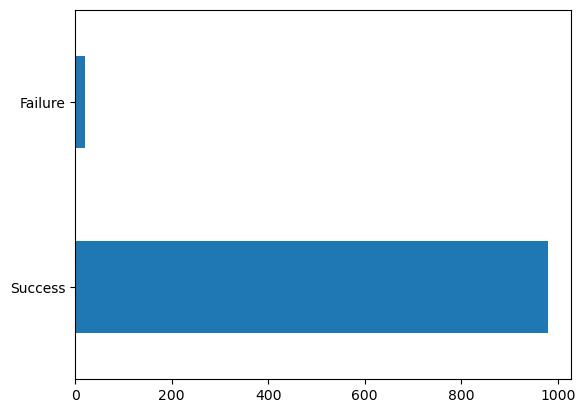

In [16]:
seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):

    treatment = np.tile([0,1],int(0.5*nPatients))
    
    deathProb = np.full(nPatients, controlDeathProb)
    deathProb[treatment==1] = treatmentDeathProb
    deathOutcome = rng.binomial(1, deathProb)

    RCTs.loc[i,['OR','pValue','LCI','UCI']] = myLogisticRegression(treatment, deathOutcome)

RCTs.success = determineSuccess(RCTs.OR, RCTs.pValue, statSigThreshold)

A vast majority of our trials are successes, so our studies have enough statistical power to measure a treatment effect of this size.
### With a covariate: patient age
We are going to add in patient age as a covariate that affects their outcome. First we must choose a random distribution for this variable, and for simplicity we will use a uniform distribution. In our code we will implement this with the line `age = rng.uniform(minAge,maxAge,nPatients)` so lets first set these minimum and maximum age variables.

In [18]:
minAge = 18
maxAge = 80

Now we need to decide how age is going to impact mortality. As a very basic example, let's assume the fatality of this disease suddenly increases above a certain age, `ageDeathThreshold`. This means we'll need the following variables.

In [20]:
ageDeathThreshold = 29
youngDeathProb = 0.1
oldDeathProb = 0.5

Now we make a new dataframe and re-initialize the RNG, then run new simulated RCTs with outcome now dependent on age.

Success    923
Failure     77
Name: count, dtype: int64


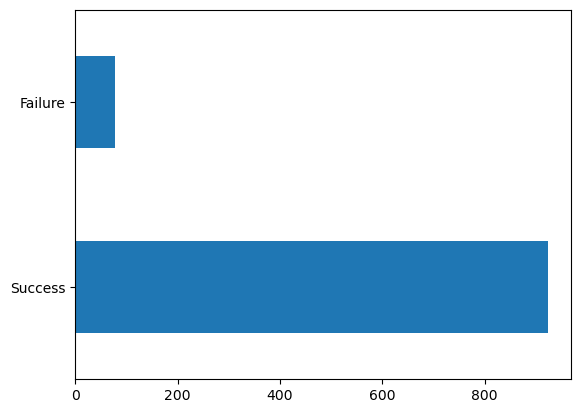

In [22]:
RCTsCov = pd.DataFrame(
    columns=['OR','pValue','LCI','UCI','success'],
    index = range(nSims)
)

seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):

    treatment = np.tile([0,1],int(0.5*nPatients))

    age = rng.uniform(minAge, maxAge, nPatients)
        
    deathProb = np.zeros(nPatients)
    deathProb[age < ageDeathThreshold] = youngDeathProb
    deathProb[age >= ageDeathThreshold] = oldDeathProb
    deathProb[treatment==1] *= treatmentRelativeRisk
    deathOutcome = rng.binomial(1, deathProb)

    RCTsCov.loc[i,['OR','pValue','LCI','UCI']] = myLogisticRegression(treatment, deathOutcome)

RCTsCov.success = determineSuccess(RCTsCov.OR, RCTsCov.pValue, statSigThreshold)

We have a lot more failed trials but the overall success rate is still very good.

<br></br>
<hr style="border:1px solid gray">
<br></br>

## Simulating an observational study
Let's see what happens when treatment isn't completely randomized and instead depends on age, as it likely would in an observational study. This will introduce confounding bias since age is going to affect both outcome and treatment status, leading to correlations between the two.

We are going to again look at a simple scenario where the probability of treatment suddenly increases above a certain age. For an extra simplification we are going to reuse the age threshold and probabilities for the survival outcomes.

This isn't completely unrealistic, as treatments are given more often to those most at risk.

In [24]:
minAge = 18
maxAge = 80
ageDeathThreshold = 29
youngDeathProb = 0.05
oldDeathProb = 0.6

ageTreatmentThreshold = ageDeathThreshold
youngTreatmentProb = youngDeathProb
oldTreatmentProb = oldDeathProb

Now we re-initialize then run our observational simulations.

Failure    998
Success      2
Name: count, dtype: int64


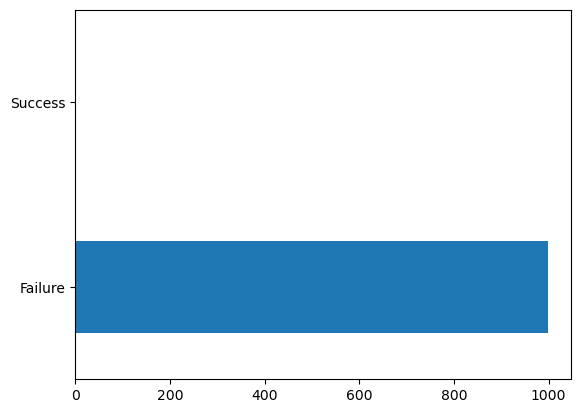

In [26]:
ObsTrials = pd.DataFrame(
    columns=['OR','pValue','LCI','UCI','success'],
    index = range(nSims)
)

seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):
    age = rng.uniform(minAge,maxAge,nPatients)
        
    treatmentProb = np.zeros(nPatients)
    treatmentProb[age < ageTreatmentThreshold] = youngTreatmentProb
    treatmentProb[age >= ageTreatmentThreshold] = oldTreatmentProb
    treatment = rng.binomial(1, treatmentProb)
        
    deathProb = np.zeros(nPatients)
    deathProb[age < ageDeathThreshold] = youngDeathProb
    deathProb[age >= ageDeathThreshold] = oldDeathProb
    deathProb[treatment==1] *= treatmentRelativeRisk
    deathOutcome = rng.binomial(1, deathProb)

    ObsTrials.loc[i,['OR','pValue','LCI','UCI']] = myLogisticRegression(treatment, deathOutcome)
    
ObsTrials.success = determineSuccess(ObsTrials.OR, ObsTrials.pValue, statSigThreshold)

We almost exclusively have failed trials! Why is this? Let's look at the odds ratios from these regressions.

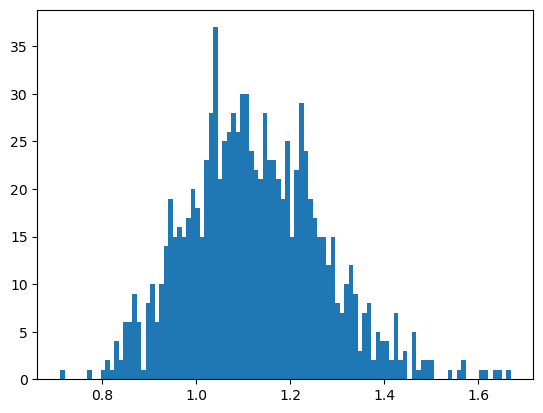

In [28]:
counts, binEdges, patches =  plt.hist(ObsTrials.OR, bins = 100)

Lots of the odds ratios are greater than one, suggesting a negative treatment effect! The reason we are seeing this is because in the observational data treatment is negatively correlated with survival. Essentially, the logistic regression models are learning that in this "real" healthcare scenario treatment predicts death - not because the treatment kills people but because the patients receiving the treatment are the ones that have a higher chance of dying.

### Including the covariate in the model
The solution to this problem is kind of obvious: we should exclude patients younger than `minTreatmentAge` from the observational sample. This kind of restricted inclusion criteria is often used in practice (e.g., including only non-smokers in a study), although it limits sample size and makes results only applicable to the restricted population. However, imagine we don't know none of our younger patients are receiving the treatment, but we do suspect age to be a confounding variable. One way we might try to improve our analysis is to include age as another independent variable $A$ in our logistic regression model, as follows
$$ P(D=1|T,A) = \left[1+\exp\left(-\beta_0 - \beta_1 T + \beta_2 A\right)\right]^{-1}.$$
Let's rerun our observational simulations using this multivaraite logistic model and see if there's any improvement.

Failure    771
Success    229
Name: count, dtype: int64


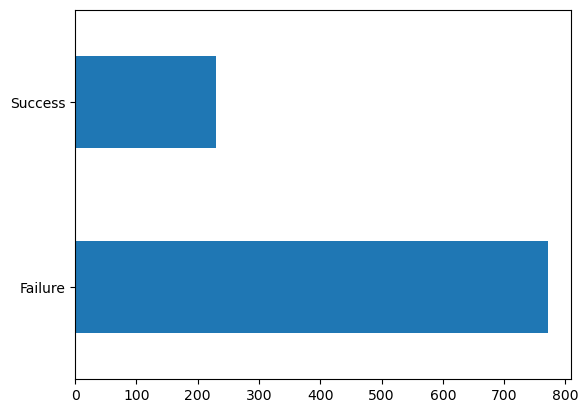

In [30]:
ObsTrialsCov = pd.DataFrame(columns=['OR','pValue','LCI','UCI','success'], index = range(nSims))

seed = 42
rng = np.random.default_rng(seed)

for i in range(nSims):
    age = rng.uniform(minAge,maxAge,nPatients)
        
    treatmentProb = np.zeros(nPatients)
    treatmentProb[age < ageTreatmentThreshold] = youngTreatmentProb
    treatmentProb[age >= ageTreatmentThreshold] = oldTreatmentProb
    treatment = rng.binomial(1, treatmentProb)
    
    deathProb = np.zeros(nPatients)
    deathProb[age < ageDeathThreshold] = youngDeathProb
    deathProb[age >= ageDeathThreshold] = oldDeathProb
    deathProb[treatment==1] *= treatmentRelativeRisk
    deathOutcome = rng.binomial(1, deathProb)
    
    inputs = np.transpose([treatment,age])
    ObsTrialsCov.loc[i,['OR','pValue','LCI','UCI']] = myLogisticRegression(inputs, deathOutcome)
    
ObsTrialsCov.success = determineSuccess(ObsTrialsCov.OR, ObsTrialsCov.pValue, statSigThreshold)

This is a big improvement on the previous observational results, but still much worse than the RCTs.
<br></br>
<br></br>
<hr style="border:1px solid gray">
<hr style="border:1px solid gray">
<br></br>

## Extensions
<br></br>
<hr style="border:1px solid gray">
<br></br>

### Extension 1 - RCT with attrition

Go back to the RCT simulation, and see what happens if you delete entries from the outcome array. This simulates a trial with attrition - participants dropping out. For this extension you have to decide two things - which entries to delete, and how to deal with missing outcomes.

- For which entries to delete, try the following three scenarios
    1. Missing completely at random - participants drop out randomly
    1. Missing at random - e.g. participants drop out randomly from just the treatment group
    1. Missing not at random - e.g. participants drop out randomly if they died
<br></br>

- For the analysis, try the following options:
    1. Per protocol analysis - ignore patients with missing outcomes
    1. Imputation - fill missing outcome entries with either survival or death

<br></br>
<hr style="border:1px solid gray">
<br></br>

### Extension 2 - RCT with non-adherence

Go back to the RCT simulation with a covariate, and see what happens if you change the treatment array after it is initialised, but before outcomes are determined. This simulates a trial with non-adherence - participants not complying with their assigned treatment in one way or another. For this to impact the results you will need the probability of non-adherence to depend on the covariate (and hence the outcome probability).

You need to decide which treatment entries to flip, and deal with non-adherence.

- For which entries to flip, try combinations of the following:
    1. Contamination - control group participants getting the treatment
    1. Non-compliance - treatment group participants not getting or taking the treatment
<br></br>

- For the analysis, try the following options:
    1. As-treated analysis - Analyse participants according to the new treatment array
    1. Intention-to-treat analysis - Analyse participants according to the original randomised treatment
    
For the intention-to-treat analysis you'll need to save a copy of the original randomised treatment array before you flip some of the entries.